Regression in real state 
========================

A partir de um dataset com dados de imóveis (metragem, cidade, bairro, quartos, etc), queremos prever o valor de cada registro usando redes neurais.

O dataset foi obtido a partir de _webscrapping_ em sites de publicação de anúncios 

## Imports

In [106]:
%load_ext autoreload
%autoreload 2

from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math 

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from keras.layers import Dense, Activation, Dropout, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import sys

sys.path.insert(1, '../')

from src.plot import plot_heatmap
from src.train import get_all_subsets, results_regression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Config

In [107]:
# Evita mostrar números em formato científico (para melhor visualização)
np.set_printoptions(suppress=True)

# tamanhos padrão e visualização de plots
PLOT_WIDE = (14,7)
PLOT_MEDIUM = (10,8)
sns.set_style("darkgrid")

## Load data

In [108]:
data = pd.read_csv('./../../../../../python/other_python/zap-project/results/imoveis_data.csv')

In [109]:
data.shape

(20709, 12)

In [110]:
data.head()

,Unnamed: 0,id,size,rooms,wc,garage_spots,price,neighborhood,city,update_time,price_sqm,link
0,0.0,2528927815,130,3,3,2,2550000,Cabo Branco,João Pessoa,2023-08-16 19:33:46,19615.384615,NaN
1,1.0,2641054378,102,3,4,0,777695,Altiplano Cabo Branco,João Pessoa,2023-08-16 19:33:46,7624.460784,NaN
2,2.0,2617664208,66,3,1,1,755000,Ponta do Seixas,João Pessoa,2023-08-16 19:33:46,11439.393939,NaN
3,3.0,2612089563,108,3,3,1,375000,Tambaú,João Pessoa,2023-08-16 19:33:46,3472.222222,NaN
4,4.0,2530653710,57,2,2,1,178000,Ernesto Geisel,João Pessoa,2023-08-16 19:33:46,3122.807018,NaN


## Preprocessing

In [111]:
# fields numbers
list(enumerate(data.columns))

[(0, 'Unnamed: 0'),
 (1, 'id'),
 (2, 'size'),
 (3, 'rooms'),
 (4, 'wc'),
 (5, 'garage_spots'),
 (6, 'price'),
 (7, 'neighborhood'),
 (8, 'city'),
 (9, 'update_time'),
 (10, 'price_sqm'),
 (11, 'link')]

In [112]:
# Limpar colunas desnecessárias 
data.drop(data.columns[[0, 1, 5, 8, 9, 10, 11]], axis=1, inplace=True)

In [113]:
data.head()

,size,rooms,wc,price,neighborhood
0,130,3,3,2550000,Cabo Branco
1,102,3,4,777695,Altiplano Cabo Branco
2,66,3,1,755000,Ponta do Seixas
3,108,3,3,375000,Tambaú
4,57,2,2,178000,Ernesto Geisel


In [114]:
# missing values
data.isna().sum()

size            0
rooms           0
wc              0
price           0
neighborhood    0
dtype: int64

In [115]:
# Duplicates
data.drop_duplicates(keep='first', inplace=True)
data.duplicated().sum()

0

In [116]:
# nas características rooms, wc e garage_spots temos alguns valores não numéricos que indicam, por exemplo 2-3 \
# vamos rodar uma função para calcular a média desses valores e ter um resultado mais acurado 
data.rooms.unique()

array(['3', '2', '4', '20', '1', '5', '17', '6', '1 - 2', '2 - 3', '8',
       '13', '3 - 4', '1 - 3'], dtype=object)

In [117]:
# Tratamento de valores numéricos que estão constando como str
# por exemplo: rooms nem sempre é número: 1 - 2

def update_data(i):
    output = None
    try:
        output = int(i)
    except:
        output = np.array(i.split(' - ')).astype(int).mean()
    
    return output

assert update_data('1') == 1, 'Não foi possível castear to int'
assert update_data('2 - 3') == 2.5, 'Não foi possível castear to int'


In [118]:
# Atualizar 3 colunas
for col in list(data.iloc[:, :4].select_dtypes('object').columns):
    data[col] = data[col].map(lambda x : update_data(x)).astype(float)

data.dtypes, data.head()

(size              int64
 rooms           float64
 wc              float64
 price             int64
 neighborhood     object
 dtype: object,
    size  rooms   wc    price           neighborhood
 0   130    3.0  3.0  2550000            Cabo Branco
 1   102    3.0  4.0   777695  Altiplano Cabo Branco
 2    66    3.0  1.0   755000        Ponta do Seixas
 3   108    3.0  3.0   375000                 Tambaú
 4    57    2.0  2.0   178000         Ernesto Geisel)

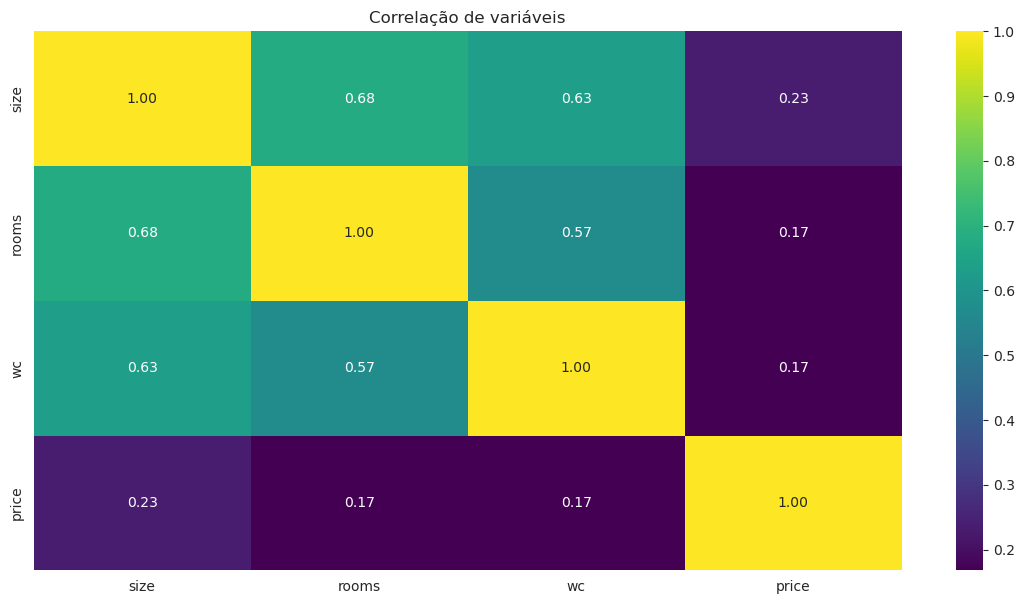

In [119]:
plot_heatmap(data.corr(numeric_only=True), \
             'Correlação de variáveis')

In [120]:
data.head()

,size,rooms,wc,price,neighborhood
0,130,3.0,3.0,2550000,Cabo Branco
1,102,3.0,4.0,777695,Altiplano Cabo Branco
2,66,3.0,1.0,755000,Ponta do Seixas
3,108,3.0,3.0,375000,Tambaú
4,57,2.0,2.0,178000,Ernesto Geisel


In [121]:
# Aplicando one-hot encoding na coluna 'neighborhood'
data = pd.get_dummies(data, columns=['neighborhood'], prefix='neighborhood', drop_first=True)

In [122]:
data.isna().sum().sum()

0

## Particionamento da base

In [123]:
y = data['price']
X = data.drop('price', axis=1)

In [124]:
# Normalizar
y /= np.max(y)
X /= np.max(X, axis=0)

In [125]:
X_train, X_val, X_test, y_train, y_val, y_test = get_all_subsets(X, y)

In [126]:
# split train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [127]:
# split train, validate
# do conjunto de treino, selecionar 20% para validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [128]:
print('X_train: ', X_train.shape)
print('X_val: ', X_val.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_val: ', y_val.shape)
print('y_test: ', y_test.shape)


X_train:  (10880, 154)
X_val:  (2720, 154)
X_test:  (3401, 154)
y_train:  (10880,)
y_val:  (2720,)
y_test:  (3401,)


## Treinamento, definição de arquitetura

In [129]:
dropout_pct = 0.3
shape = (X_train.shape[1],)

display(shape)

model = Sequential()
model.add(Dense(units=512, activation='relu', input_shape=shape))
model.add(Dropout(dropout_pct))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(dropout_pct))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(dropout_pct))

model.add(Dense(units=1))

model.summary()

(154,)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               79360     
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                

## Definição de otimizadores

In [130]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [131]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, \
                   patience=10, verbose=1, mode='auto')

historico = model.fit(X_train,
                      y_train,
                      epochs=1000,
                      batch_size=32,
                      verbose=1,
                      validation_data=(X_val, y_val),
                      callbacks=[es])


Epoch 1/1000


340/340 [==============================] - 2s 3ms/step - loss: 2.2357e-04 - mae: 0.0070 - val_loss: 3.7761e-04 - val_mae: 0.0022
Epoch 2/1000
340/340 [==============================] - 1s 3ms/step - loss: 6.0814e-05 - mae: 0.0026 - val_loss: 3.7658e-04 - val_mae: 0.0028
Epoch 3/1000
340/340 [==============================] - 1s 3ms/step - loss: 5.8150e-05 - mae: 0.0024 - val_loss: 3.7836e-04 - val_mae: 0.0022
Epoch 4/1000
340/340 [==============================] - 1s 3ms/step - loss: 5.7968e-05 - mae: 0.0023 - val_loss: 3.7678e-04 - val_mae: 0.0022
Epoch 5/1000
340/340 [==============================] - 1s 3ms/step - loss: 5.7646e-05 - mae: 0.0023 - val_loss: 3.7704e-04 - val_mae: 0.0022
Epoch 6/1000
340/340 [==============================] - 1s 3ms/step - loss: 5.7136e-05 - mae: 0.0022 - val_loss: 3.7657e-04 - val_mae: 0.0022
Epoch 7/1000
340/340 [==============================] - 1s 3ms/step - loss: 5.6771e-05 - mae: 0.0022 - val_loss: 3.7588e-04 - val_mae: 0.0024
Epoch 8/1000
340/34

In [132]:
y_pred = model.predict(X_test)

107/107 [==============================] - 0s 1ms/step


## Avaliação do modelo

In [133]:
results_regression(y_test, y_pred.flatten(), True)

MSE: 0.0001803024715962548
Erro médio quadrático (RMSE): 0.013427675584264567
Erro médio absoluto (MAE): 0.00401786171934225
Erro de porcentagem absoluta média (MAPE): 1.0
R2 Score: -0.09833872858413994


(0.0001803024715962548,
 0.013427675584264567,
 0.00401786171934225,
 1.0,
 -0.09833872858413994)

In [886]:
results = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred.flatten()
    })

results['diff'] = y_test/y_pred.flatten()
display(results.sample(10), results['diff'].mean())

,y_test,y_pred,diff
8546,0.002177,0.004639,0.469257
7826,0.001707,0.004680,0.364861
12157,0.003265,0.004653,0.701800
16206,0.003322,0.004718,0.704096
1214,0.000878,0.004630,0.189555
14866,0.003381,0.004628,0.730571
15682,0.022789,0.006178,3.688840
7793,0.013204,0.006317,2.090096
10127,0.002585,0.004634,0.557825
14989,0.003735,0.004741,0.787772


0.8073811088591542